In [1]:
!pip install torch torchvision transformers sentence-transformers pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
# Replace with your file path
!unzip /content/test_images.zip -d /content/similarity_images.zip


Archive:  /content/test_images.zip
   creating: /content/similarity_images.zip/test_images/
  inflating: /content/similarity_images.zip/test_images/cat_1.avif  
  inflating: /content/similarity_images.zip/test_images/cat_2.avif  
  inflating: /content/similarity_images.zip/test_images/cat_3.avif  
  inflating: /content/similarity_images.zip/test_images/cat_4.avif  
  inflating: /content/similarity_images.zip/test_images/dog_1.avif  
  inflating: /content/similarity_images.zip/test_images/dog_2.avif  
  inflating: /content/similarity_images.zip/test_images/dog_3.avif  
  inflating: /content/similarity_images.zip/test_images/dog_4.avif  


In [3]:
!pip install pillow-avif-plugin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 57.7 MB/s eta 0:00:00


In [5]:
from PIL import Image
import pillow_avif  # Ensure AVIF support is registered
import os

# ----------------------------
# 1. Input & output directories
# ----------------------------
input_dir = 'test_images'       # your AVIF images folder
output_dir = 'converted_images' # output folder

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# ----------------------------
# 2. Loop through AVIF files in the input folder
# ----------------------------
for file in os.listdir(input_dir):
    if file.lower().endswith('.avif'):
        avif_path = os.path.join(input_dir, file)
        with Image.open(avif_path) as img:
            img = img.convert("RGB")
            output_path = os.path.join(output_dir, file.replace('.avif', '.jpg'))
            img.save(output_path, format='JPEG')
            print(f"[INFO] Converted: {file} -> {output_path}")

print("[INFO] Conversion complete. Check the 'converted_images/' folder.")


[INFO] Converted: cat_4.avif -> converted_images/cat_4.jpg
[INFO] Converted: dog_3.avif -> converted_images/dog_3.jpg
[INFO] Converted: cat_2.avif -> converted_images/cat_2.jpg
[INFO] Converted: cat_1.avif -> converted_images/cat_1.jpg
[INFO] Converted: dog_1.avif -> converted_images/dog_1.jpg
[INFO] Converted: dog_2.avif -> converted_images/dog_2.jpg
[INFO] Converted: cat_3.avif -> converted_images/cat_3.jpg
[INFO] Converted: dog_4.avif -> converted_images/dog_4.jpg
[INFO] Conversion complete. Check the 'converted_images/' folder.


In [6]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch
import os
import json

image_directory = "converted_images"

# Load BLIP2 model
print("Loading BLIP2 model...")
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

image_files = [f for f in os.listdir(image_directory)
               if os.path.isfile(os.path.join(image_directory, f))
               and f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

print(f"Found {len(image_files)} images in the directory")

captions = {}
for image_file in image_files:
    full_image_path = os.path.join(image_directory, image_file)

    try:
        image = Image.open(full_image_path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt").to(model.device)
        output = model.generate(**inputs, max_length=50)
        caption = processor.decode(output[0], skip_special_tokens=True)

        # Store caption
        captions[image_file] = caption
        print(f"Image: {image_file}")
        print(f"Caption: {caption}")
        print("-" * 50)

    except Exception as e:
        print(f"Error processing {image_file}: {str(e)}")

# captions in json
with open('image_captions.json', 'w') as f:
    json.dump(captions, f, indent=2)

print(f"Processed {len(captions)} images. Captions saved to image_captions.json")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading BLIP2 model...


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Found 8 images in the directory
Image: dog_3.jpg
Caption: a small brown dog with blue eyes sitting on a tile floor
--------------------------------------------------
Image: cat_3.jpg
Caption: a jaguar resting on a rock
--------------------------------------------------
Image: dog_2.jpg
Caption: a dog sitting on a bed with a mirror above it
--------------------------------------------------
Image: cat_2.jpg
Caption: a small tiger walking through the jungle
--------------------------------------------------
Image: cat_4.jpg
Caption: a gray cat laying on a yellow couch
--------------------------------------------------
Image: cat_1.jpg
Caption: a cat with yellow eyes sitting in the grass
--------------------------------------------------
Image: dog_4.jpg
Caption: two wolves are seen in the snow
--------------------------------------------------
Image: dog_1.jpg
Caption: a small dog sitting on top of a bed
--------------------------------------------------
Processed 8 images. Captions save

In [7]:
from sentence_transformers import SentenceTransformer
import json
import numpy as np
import pickle

print("Loading captions...")
with open('image_captions.json', 'r') as f:
    captions = json.load(f)

print(f"Loaded captions for {len(captions)} images")

# Sentence transformer
print("Loading sentence transformer model...")
model = SentenceTransformer('all-MiniLM-L6-v2')


image_files = list(captions.keys())
caption_texts = [captions[img] for img in image_files]
print("Generating embeddings...")
embeddings = model.encode(caption_texts, show_progress_bar=True)

# Map images to their embeddings for retireval
embedding_dict = {}
for i, img_file in enumerate(image_files):
    embedding_dict[img_file] = embeddings[i]
with open('caption_embeddings.pkl', 'wb') as f:
    pickle.dump(embedding_dict, f)

print(f"Generated embeddings for {len(embedding_dict)} captions")
print(f"Embedding dimension: {embeddings[0].shape}")
print("Embeddings saved to caption_embeddings.pkl")

Loading captions...
Loaded captions for 8 images
Loading sentence transformer model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating embeddings...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generated embeddings for 8 captions
Embedding dimension: (384,)
Embeddings saved to caption_embeddings.pkl


Loading embeddings and captions...
Calculating similarities among 8 images
Finding images similar to: dog_3.jpg
Caption: a small brown dog with blue eyes sitting on a tile floor

Most similar images:
dog_1.jpg (Similarity: 0.5122)
Caption: a small dog sitting on top of a bed
--------------------------------------------------
cat_1.jpg (Similarity: 0.4528)
Caption: a cat with yellow eyes sitting in the grass
--------------------------------------------------
dog_2.jpg (Similarity: 0.4249)
Caption: a dog sitting on a bed with a mirror above it
--------------------------------------------------
cat_4.jpg (Similarity: 0.2927)
Caption: a gray cat laying on a yellow couch
--------------------------------------------------
cat_2.jpg (Similarity: 0.2775)
Caption: a small tiger walking through the jungle
--------------------------------------------------


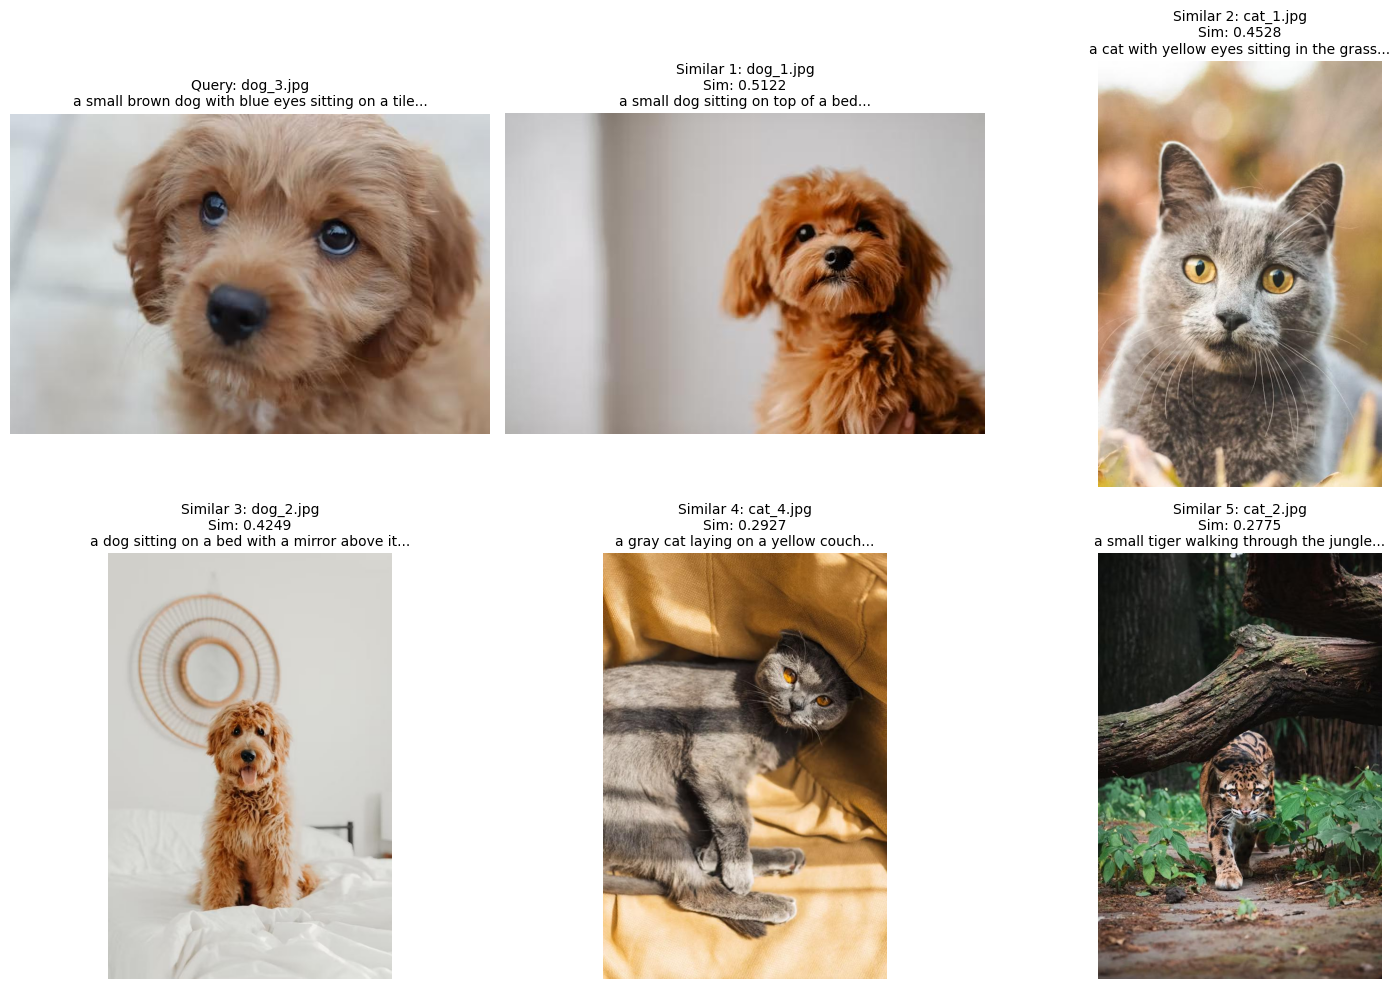

In [8]:
import pickle
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import json
from PIL import Image
import matplotlib.pyplot as plt
import os

# Load embeddings and captions
print("Loading embeddings and captions...")
with open('caption_embeddings.pkl', 'rb') as f:
    embedding_dict = pickle.load(f)

with open('image_captions.json', 'r') as f:
    captions = json.load(f)


image_directory = "converted_images"

# embedding keys of respective images
image_files = list(embedding_dict.keys())
print(f"Calculating similarities among {len(image_files)} images")
embedding_matrix = np.array([embedding_dict[img] for img in image_files])

#cosine similarity
similarity_matrix = cosine_similarity(embedding_matrix)

# Function to get similar images for a query image
def get_similar_images(query_image, top_n=5):
    if query_image not in embedding_dict:
        print(f"Image {query_image} not found in the dataset")
        return []

    query_idx = image_files.index(query_image)
    similarities = similarity_matrix[query_idx]
    similarities_copy = similarities.copy()
    similarities_copy[query_idx] = -1

    # Get indices of top N similar images
    top_indices = np.argsort(similarities_copy)[-top_n:][::-1]

    # Return list of (image_file, similarity) tuples
    similar_images = [(image_files[idx], similarities[idx]) for idx in top_indices]

    return similar_images

def visualize_similar_images(query_image, similar_images):
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 3, 1)
    img = Image.open(os.path.join(image_directory, query_image))
    plt.imshow(img)
    plt.title(f"Query: {query_image}\n{captions[query_image][:50]}...", fontsize=10)
    plt.axis('off')

    for i, (img_file, similarity) in enumerate(similar_images):
        plt.subplot(2, 3, i+2)
        img = Image.open(os.path.join(image_directory, img_file))
        plt.imshow(img)
        plt.title(f"Similar {i+1}: {img_file}\nSim: {similarity:.4f}\n{captions[img_file][:50]}...",
                  fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('similar_images.png')
    plt.show()

# Example: Find and visualize similar images for the first image in the dataset
example_query = image_files[0]
print(f"Finding images similar to: {example_query}")
print(f"Caption: {captions[example_query]}")

similar_images = get_similar_images(example_query, top_n=5)
print("\nMost similar images:")
for img, sim in similar_images:
    print(f"{img} (Similarity: {sim:.4f})")
    print(f"Caption: {captions[img]}")
    print("-" * 50)

# Visualize the results
visualize_similar_images(example_query, similar_images)

# Interactive query function
def query_similar_images():
    print("\nEnter image filename to find similar images (or 'exit' to quit):")
    while True:
        query = input("> ")
        if query.lower() == 'exit':
            break

        if query not in embedding_dict:
            print(f"Image '{query}' not found. Available images:")
            # Show some available images
            for img in list(embedding_dict.keys())[:5]:
                print(f"- {img}")
            print(f"... and {len(embedding_dict)-5} more")
            continue

        similar = get_similar_images(query, top_n=5)
        visualize_similar_images(query, similar)